Dados carregados. Linhas: 1440
Perfil diário (primeiras linhas):
   hour  consumption_kwh  solar_generation_kw  occupancy
0     0         0.266050                  0.0   0.016667
1     1         0.301567                  0.0   0.050000
2     2         0.306083                  0.0   0.050000
3     3         0.364917                  0.0   0.050000
4     4         0.326883                  0.0   0.066667


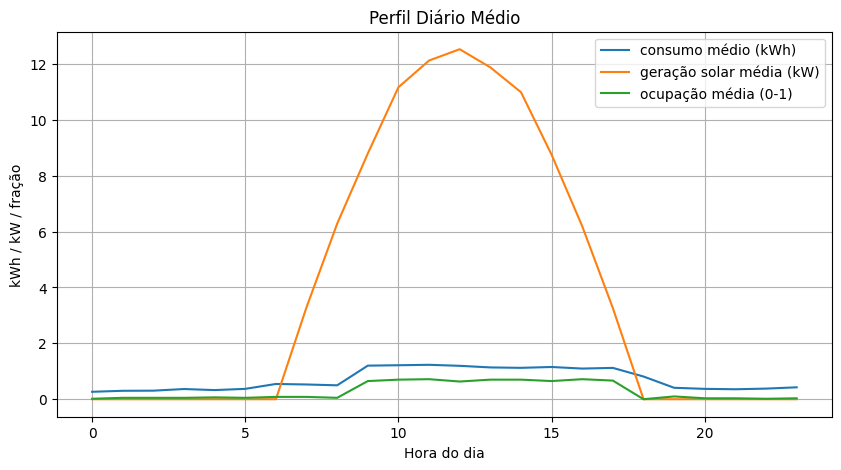

Top 10 picos de consumo:
          timestamp  consumption_kwh  occupancy  equipment_on_count  temperature_c
2025-10-15 13:00:00            3.680          1                   3          22.01
2025-09-24 12:00:00            2.218          1                   7          24.18
2025-10-11 10:00:00            2.185          0                   0          24.63
2025-10-02 03:00:00            2.169          0                   0          23.33
2025-09-11 07:00:00            2.140          0                   0          24.02
2025-09-01 12:00:00            2.079          1                   7          22.69
2025-10-02 11:00:00            2.079          1                   5          22.23
2025-09-01 01:00:00            2.044          0                   0          20.82
2025-09-18 12:00:00            2.015          1                   5          23.86
2025-09-17 15:00:00            2.013          1                   6          19.15
Simulação de automação: {'total_before_kwh': np.float64(1004.2

In [6]:
# main_colab.py
# Script pronto para Colab para o projeto SIGE-W.

# Este script:
# - carrega o conjunto de dados simulados consumo_simulado.csv
# - Exibe análises básicas: perfis diários, horários de pico, cenários simples de economia
# - Gera gráficos (matplotlib; sem seaborn)
# Uso no Colab:
# - Carregue o arquivo CSV fornecido no ambiente Colab (ou monte o Drive)
# - Execute este script ou cole suas células em um notebook
# Dependências:
# - pandas, numpy, matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = "/content/consumo_simulado.csv"

def load_data(path=DATA_PATH):
    df = pd.read_csv(path, parse_dates=["timestamp"])
    return df

def daily_consumption_profile(df):
    # Agrupa por hora e calcula o consumo médio e a geração solar
    gp = df.groupby("hour").agg({
        "consumption_kwh":"mean",
        "solar_generation_kw":"mean",
        "occupancy":"mean"
    }).reset_index()
    return gp

def plot_daily_profile(gp):
    plt.figure(figsize=(10,5))
    plt.plot(gp["hour"], gp["consumption_kwh"], label="consumo médio (kWh)")
    plt.plot(gp["hour"], gp["solar_generation_kw"], label="geração solar média (kW)")
    plt.plot(gp["hour"], gp["occupancy"], label="ocupação média (0-1)")
    plt.xlabel("Hora do dia")
    plt.ylabel("kWh / kW / fração")
    plt.title("Perfil Diário Médio")
    plt.legend()
    plt.grid(True)
    plt.show()

def detect_peak_hours(df, top_n=5):
    # Encontra as horas (timestamp) com maior consumo
    top = df.sort_values("consumption_kwh", ascending=False).head(top_n)
    return top[["timestamp","consumption_kwh","occupancy","equipment_on_count","temperature_c"]]

def simulate_automation_savings(df):
    # Regra simples: if occupancy==0 -> reduzir consumption by 25% (simulação de desligamento de equipamentos não essenciais)
    df2 = df.copy()
    mask = df2["occupancy"]==0
    df2.loc[mask, "consumption_kwh_after"] = df2.loc[mask, "consumption_kwh"] * 0.75
    df2.loc[~mask, "consumption_kwh_after"] = df2.loc[~mask, "consumption_kwh"]
    total_before = df2["consumption_kwh"].sum()
    total_after = df2["consumption_kwh_after"].sum()
    savings_kwh = total_before - total_after
    savings_pct = savings_kwh / total_before * 100
    return {"total_before_kwh":total_before, "total_after_kwh":total_after, "savings_kwh":savings_kwh, "savings_pct":savings_pct, "df":df2}

def simulate_solar_offset(df, capacity_kw):
    # aproximado: solar_generation_kw é por hora kW; energia produzida por hora ~ kW * 1h
    df2 = df.copy()
    df2["solar_kw_scaled"] = df2["solar_generation_kw"] * (capacity_kw / df2["solar_generation_kw"].max())
    df2["net_consumption"] = df2["consumption_kwh"] - df2["solar_kw_scaled"]
    df2["net_consumption"] = df2["net_consumption"].clip(lower=0)
    total_consumption = df2["consumption_kwh"].sum()
    total_net = df2["net_consumption"].sum()
    offset_kwh = total_consumption - total_net
    offset_pct = offset_kwh / total_consumption * 100
    return {"total_consumption":total_consumption, "total_net":total_net, "offset_kwh":offset_kwh, "offset_pct":offset_pct, "df":df2}

if __name__ == "__main__":
    df = load_data()
    print("Dados carregados. Linhas:", len(df))
    gp = daily_consumption_profile(df)
    print("Perfil diário (primeiras linhas):")
    print(gp.head())
    plot_daily_profile(gp)
    peaks = detect_peak_hours(df, top_n=10)
    print("Top 10 picos de consumo:")
    print(peaks.to_string(index=False))
    sav = simulate_automation_savings(df)
    print("Simulação de automação:", {k: (round(v,2) if isinstance(v,(int,float)) else v) for k,v in sav.items() if k!='df'})
    solar = simulate_solar_offset(df, capacity_kw=15.0)
    print("Simulação solar (15 kW):", {k: (round(v,2) if isinstance(v,(int,float)) else v) for k,v in solar.items() if k!='df'})